In [4]:
%matplotlib inline
import os
import re
from StringIO import StringIO
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from skimage import measure, io
import matplotlib.pyplot as plt
import mahotas as mh
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib

/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
def open_gdocs(url):
    import requests
    r = requests.get(url, verify=False)
    data = r.content
    df = pd.read_csv(StringIO(data), decimal=b',')
    return df

In [6]:
def save_fig(fig, output_filepath, dpi=72, use_tl=True):
    output_path, filename = os.path.split(output_filepath)
        
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    if use_tl:
        plt.tight_layout()
        
    fig.savefig(output_filepath, dpi=dpi)

In [7]:
def number(val):
    if val < 1000:
        return '%d' % val
        
    sv = str(val)
    return '$\mathregular{10^{%d}}$' % (len(sv)-2) if val % 10 == 0 else '%0.0e' % val

In [8]:
def get_data_by_type(path, type, unit_scale=1.8):
    if type == 'p':
        data = pd.read_csv(path)['area'] * (unit_scale**3)
    elif type == 'd':
        data = np.load(path).item()
        data = data['diameter']
        data = data * unit_scale * 2
    else:
        return None
    
    return data

In [9]:
def get_result_path(sample_name, input_dir, type='o', window_size=32, nsa=30):
    if type == 'd':
        return os.path.join(input_dir, '{sample_name}_nsa{nsa}_diameter_evaluation.npy'.format(sample_name=sample_name, nsa=nsa))
    elif type == 'o':
        return os.path.join(input_dir, '{sample_name}_w{window_size}_orientation_evaluation.npy'.format(sample_name=sample_name, window_size=window_size))
    elif type == 'p':
        return os.path.join(input_dir, sample_name, 'particles_stats_{sample_name}.csv'.format(sample_name=sample_name))
    else:
        return None

In [10]:
DEF_COLOR = ['#ae4900', '#c75400', '#e15e00', '#ff862e', '#ff862e']

COLORS = {
    'sample21': ['#93000B', '#B4000C', '#CF0010', '#E03140', '#E87980'],
    'sample22': ['#094F80', '#086EB0', '#2A80B9', '#4995C7', '#72AFDB']
}

NAMES = {
    'sample21': 'S21',
    'sample22': 'S22'
}

In [11]:
def plot_complex_hist(input_dir, output_dir, charts_params, type='p', window_size=32, unit_scale=1.8, scale=2):
    for sample_name, chart_params in charts_params.items():
        fig = plt.figure(figsize=(27*scale,15*scale))
        
        for chart_param in chart_params:
            dpy_path = get_result_path(sample_name, input_dir, type=type)
            dpy = pd.read_csv(dpy_path)['area'] * (unit_scale**3)

            nbins, vmin, vmax = chart_param['range']
            dpy_lim = dpy[(dpy >= vmin) & (dpy < vmax)]
           
            fig, ax = plot_histogram(dpy_lim,
                                   fig=fig,
                                   splot_index=chart_param['pidx'],
                                   scale=scale,
                                   num_bins=nbins,
                                   color=chart_param['color'],
                                   xlabel=chart_param['xlabel'],
                                   ylabel=chart_param['ylabel'],
                                   xlim=(vmin, vmax),
                                   labelpad=15,
                                   exp_fontsize=25,
                                   labels_fontsize=30,
                                   grid_alpha=0.3,
                                   ticks_pad=7,
                                   yticks_fontsize=30,
                                   xticks_fontsize=30,
                                   bar_width=0.8,
                                   normed=False,
                                   use_sci_xaxis=True,
                                   use_sci_yaxis=True,
                                   use_xlocator=True)

In [12]:
def create_pie_chart_plain(sample_name, input_data, output_dir, rngs, title=None, \
                           type='p', lang='en', measure_type='vol', \
                           zebra_color_idxs=None, legend_fontsize=50, chart_fontsize=60, dpi=72,
                           color_name=None):
    df = input_data
    
    print 'Max: {}, Min: {}'.format(df.max(), df.min())
    
    data_ranges = []
    for rng in rngs:
        rng_min, rng_max = rng[0], rng[1]
        data_rng = df[(df > rng_min) & (df < rng_max)]
        data_ranges.append(data_rng)
    
    num_elem = [len(p) for p in data_ranges]
    se = sum(num_elem)
    
    print 'Num of particles: {}'.format(se)

    proc_particles = [n/float(se) * 100.0 for n in num_elem]
    
    for size, rng in zip(num_elem, rngs):
        print '{}-{}: {}'.format(rng[0], rng[1], size)
                      
    def get_title(v1, v2, lang, measure_type):
        if measure_type == 'vol':
            measure_quantity = 'm^3' if lang == 'en' else u'м^3'
        else:
            measure_quantity = 'm' if lang == 'en' else u'м'
        
        ftm = '%s $\minus$ %s $\mathregular{\mu %s}$' if lang == 'en' else u'%s $\minus$ %s $\mathregular{мк%s}$'
        return ftm % (number(v1), number(v2), measure_quantity)
                      
    titles = [get_title(minv, maxv, lang, measure_type) for minv,maxv in rngs]
    
    if color_name is None:
        colors = COLORS.get(sample_name, DEF_COLOR)
    else:
        colors = COLORS.get(color_name, DEF_COLOR)
        
    textprops={'fontsize': chart_fontsize, 'weight': 'normal', 'family': 'sans-serif'}
    pie_width = 0.5
    fig, ax = plt.subplots(figsize=(33,15))
    ax.axis('equal')
    patches, texts, autotexts = ax.pie(proc_particles, \
                                       textprops=textprops, \
                                       colors=colors, \
                                       autopct='%1.1f%%', \
                                       radius=1, \
                                       pctdistance=1-pie_width/2)
    if zebra_color_idxs is not None:
        for zi in zebra_color_idxs:
            autotexts[zi].set_color('white')
    #if (zebra_color is not None) and (zebra_color[0]):
        #for tt in autotexts[:zebra_color[1]]:
            #tt.set_color('white')
    
    plt.setp(patches, \
             width=pie_width, \
             edgecolor='white')

    plt.legend(patches, titles, loc=(0.383,-0.35), fontsize=legend_fontsize)
    
    _d, _offset, _di = [1,-1, 2, -2], [0.45, 0.45, 0.45, 0.45], 0
    
    for t, p in zip(autotexts, proc_particles):
        if p < 2.0:
            pos = list(t.get_position())
            pos[0] = pos[0] + _d[_di] * _offset[_di]

            t.set_position(pos)
            _di += 1

    out_figdir = os.path.join(output_dir, sample_name)
    
    if not os.path.exists(out_figdir):
        os.makedirs(out_figdir)
    
    out_figpath = os.path.join(out_figdir, '_'.join([sample_name, title, 'pie', lang]) + '.png')
    
    plt.tight_layout()
    fig.savefig(out_figpath, bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=dpi)

In [13]:
def create_pie_chart(sample_name, input_dir, output_dir, rngs, title=None, \
                     type='p', unit_scale=1.8, lang='en', measure_type='vol', 
                     zebra_color=(False,3), legend_fontsize=50, chart_fontsize=60, dpi=72,
                     color_name=None):
    dpy_path = get_result_path(sample_name, input_dir, type=type)
    df = get_data_by_type(dpy_path, type=type, unit_scale=unit_scale)
    
    print 'Max: {}, Min: {}'.format(df.max(), df.min())
    
    data_ranges = []
    for rng in rngs:
        rng_min, rng_max = rng[0], rng[1]
        data_rng = df[(df > rng_min) & (df < rng_max)]
        data_ranges.append(data_rng)
    
    num_elem = [len(p) for p in data_ranges]
    se = sum(num_elem)
    
    print 'Num of particles: {}'.format(se)

    proc_particles = [n/float(se) * 100.0 for n in num_elem]
    
    for size, rng in zip(num_elem, rngs):
        print '{}-{}: {}'.format(rng[0], rng[1], size)
                      
    def get_title(v1, v2, lang, measure_type):
        if measure_type == 'vol':
            measure_quantity = 'm^3' if lang == 'en' else u'м^3'
        else:
            measure_quantity = 'm' if lang == 'en' else u'м'
        
        ftm = '%s $\minus$ %s $\mathregular{\mu %s}$' if lang == 'en' else u'%s $\minus$ %s $\mathregular{мк%s}$'
        return ftm % (number(v1), number(v2), measure_quantity)
                      
    titles = [get_title(minv, maxv, lang, measure_type) for minv,maxv in rngs]
    
    if color_name is None:
        colors = COLORS.get(sample_name, DEF_COLOR)
    else:
        colors = COLORS.get(color_name, DEF_COLOR)
        
    textprops={'fontsize': chart_fontsize, 'weight': 'normal', 'family': 'sans-serif'}
    pie_width = 0.5
    fig, ax = plt.subplots(figsize=(33,15))
    ax.axis('equal')
    patches, texts, autotexts = ax.pie(proc_particles, \
                                       textprops=textprops, \
                                       colors=colors, \
                                       autopct='%1.1f%%', \
                                       radius=1, \
                                       pctdistance=1-pie_width/2)
    
    if (zebra_color is not None) and (zebra_color[0]):
        for tt in autotexts[:zebra_color[1]]:
            tt.set_color('white')
    
    plt.setp(patches, \
             width=pie_width, \
             edgecolor='white')

    plt.legend(patches, titles, loc=(0.383,-0.45), fontsize=legend_fontsize)
    
    _d, _offset, _di = [1,-1, 2, -2], [0.45, 0.45, 0.45, 0.45], 0
    
    for t, p in zip(autotexts, proc_particles):
        if p < 2.0:
            pos = list(t.get_position())
            pos[0] = pos[0] + _d[_di] * _offset[_di]

            t.set_position(pos)
            _di += 1

    out_figdir = os.path.join(output_dir, sample_name)
    
    if not os.path.exists(out_figdir):
        os.makedirs(out_figdir)
    
    out_figpath = os.path.join(out_figdir, '_'.join([sample_name, title, 'pie', lang]) + '.png')
    
    plt.tight_layout()
    fig.savefig(out_figpath, bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=dpi)

In [14]:
def plot_histogram_fig(data, num_bins, xticks, color, splot_index=111,
                       xlim=(None,None), ylim=(None,None),
                       bar_width=0.8, ticks_pad=7, xticks_fontsize=22, 
                       yticks_fontsize=22, xlabel=None, ylabel=None,
                       yticks=None,
                       name=None, output_dir=None,
                       dpi=200,
                       in_percent=False,
                       labels_fontsize=20, grid_alpha=0.3, title_fontsize=22, 
                       exp_fontsize=15, type=None, figsize=(12,8), norm=True):
    import matplotlib.ticker as plticker
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(splot_index)
    
    weights = np.ones_like(data)/float(len(data))
    
    n, bins, patches = ax.hist(data, num_bins, color=color, rwidth=bar_width, weights=weights)
    print(sum(n * np.diff(bins)))

    if norm:
        mu, sigma = np.mean(data), np.std(data)
        y = mlab.normpdf(bins, mu, sigma)
        ax.plot(bins, y, '--', linewidth=2)
    
    ax.tick_params(axis='x', 
                   labelsize=xticks_fontsize, 
                   colors='#000000', 
                   which='both', 
                   direction='out', 
                   length=6, 
                   width=2, 
                   pad=ticks_pad)
    ax.tick_params(axis='x', 
                   labelsize=xticks_fontsize, 
                   colors='#000000', 
                   which='minor', 
                   direction='out', 
                   length=4, 
                   width=2,
                   pad=ticks_pad)
        
    ax.tick_params(axis='y', 
                   labelsize=yticks_fontsize, 
                   colors='#000000', 
                   which='major', 
                   direction='out', 
                   length=6, 
                   width=2,
                   pad=ticks_pad)
    ax.tick_params(axis='y', 
                   labelsize=xticks_fontsize, 
                   colors='#000000', 
                   which='minor', 
                   direction='out', 
                   length=4, 
                   width=2,
                   pad=ticks_pad)

    ax.xaxis.set_minor_locator(plticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(plticker.MultipleLocator(5))
    
    pos = np.linspace(xticks.min(), xticks.max(), num=len(xticks))
    plt.xticks(xticks, xticks)
    
    if yticks is not None:
        plt.yticks(yticks, yticks)

    if in_percent:
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.0f}'.format(x*100) for x in vals])
        
    ax.xaxis.offsetText.set_fontsize(exp_fontsize)
    ax.yaxis.offsetText.set_fontsize(exp_fontsize)
    
    if not in_percent:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2), fontsize=yticks_fontsize)
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6, min_n_ticks=5))

    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    #ax.yaxis.grid(lw=1*scale, color='#aaaaaa', alpha=grid_alpha)

    ax.set_ylabel(ylabel, labelpad=2, fontsize=labels_fontsize, color='black')
    ax.set_xlabel(xlabel, labelpad=2, fontsize=labels_fontsize, color='black')
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    ax.set_axisbelow(True)
    
    if output_dir is not None:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, name + '.png'), transparent=False, bbox_inches='tight', pad_inches=0.1, dpi=dpi)
    
    return fig, ax

In [15]:
def plot_histogram(data, fig=None, splot_index=111,
                   num_bins=50, scale=2., exp_fontsize=14, 
                   labels_fontsize=18, grid_alpha=0.4,
                   figsize=(12,8),
                   ylim=(None,None), xlim=(None,None),
                   xticks=None, yticks=None,
                   use_sci_yaxis=True, use_sci_xaxis=False,
                   ticks_pad=10, color='#19B5FE', 
                   ylabel=None, xlabel=None, 
                   yticks_fontsize=18, xticks_fontsize=18,
                   title=None, bar_width=None, 
                   title_fontsize=22,
                   labelpad=2, use_xlocator=False,
                   use_log=False, normed=True, type=None):
    if fig is None:
        fig = plt.figure(figsize=tuple([v * scale for v in figsize]))
        
    ax = fig.add_subplot(splot_index)
    
    n, bins, patches = ax.hist(data, num_bins, normed=normed, color=color, rwidth=bar_width)

    mu, sigma = np.mean(data), np.std(data)
    y = mlab.normpdf(bins, mu, sigma)
    ax.plot(bins, y, '--', linewidth=2*scale)
    
    ax.tick_params(color='black', labelcolor='black', direction='out', pad=ticks_pad*scale)
    ax.tick_params(axis='y', which='major', labelsize=yticks_fontsize*scale)
    ax.tick_params(axis='x', which='major', labelsize=xticks_fontsize*scale)
    
    if xticks is not None:
        pos = np.linspace(xticks.min(), xticks.max(), num=len(xticks))
        plt.xticks(xticks, xticks)
        
    ax.xaxis.offsetText.set_fontsize(exp_fontsize*scale)
    ax.yaxis.offsetText.set_fontsize(exp_fontsize*scale)
    
    if use_sci_yaxis:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2), fontsize=exp_fontsize*scale)
    
    if use_sci_xaxis:
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2), fontsize=exp_fontsize*scale)
    
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6, min_n_ticks=5))
    
    if use_xlocator:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(prune='lower'))
    
    ax.xaxis.grid(False)
    ax.yaxis.grid(lw=1*scale, color='#aaaaaa', alpha=grid_alpha)
    
    if ylabel is not None:
        ax.set_ylabel(ylabel, labelpad=labelpad*scale, fontsize=labels_fontsize*scale, color='black')
        
    if xlabel is not None:
        ax.set_xlabel(xlabel, labelpad=labelpad*scale, fontsize=labels_fontsize*scale, color='black')
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    ax.set_axisbelow(True)
    
    if use_log:
        ax.set_yscale('log')
    
    if title is not None:
        ax.set_title(title, fontsize=title_fontsize*scale, y=1.06)
    
    return fig, ax

In [16]:
def plot_orientation_old(dpy_path, sample_params, sample_name, input_dir, save_plot_dir, color, lang='en', dpi=300, **kwargs):
    for key, params in sample_params.items():
        skel = np.load(dpy_path).item()['skeleton']
        dpy = np.load(dpy_path).item()[key]
        dpy = np.rad2deg(dpy)
        dpy = dpy[skel > 0]
        #dpy = dpy.flatten()
        #dpy = dpy[np.where(dpy > 0)]
        
        fig, ax = plot_histogram_fig(dpy,
                                     params[2],
                                     np.linspace(params[1][0], params[1][1], num=10).astype(np.int32),
                                     color,
                                     xlim=params[1],
                                     ylim=params[3],
                                     yticks=params[4],
                                     **kwargs)
        
        out_figpath = os.path.join(save_plot_dir, sample_name)
        
        if not os.path.exists(out_figpath):
            os.makedirs(out_figpath)
        
        out_figpath = os.path.join(out_figpath, '_'.join([sample_name, key, 'orientation', lang]) + '.png')
    
        plt.tight_layout()
        fig.savefig(out_figpath, transparent=False, bbox_inches='tight', pad_inches=0.1, dpi=dpi)

In [17]:
def plot_from_samples(input_dir, sample_names, sample_params, save_plot_dir, color, dpi=300, type='o', window_size=32, **kwargs):
    for sample_name in sample_names:
        dpy_path = get_result_path(sample_name, input_dir, type=type, window_size=window_size)
        
        print 'Sample: {0} ({1})'.format(sample_name, dpy_path)
        
        if type == 'o':
            plot_orientation_old(dpy_path, sample_params, sample_name, input_dir, save_plot_dir, color, dpi=dpi, type=type, **kwargs)
        elif type == 'd':
            plot_diameter(dpy_path, sample_params, save_plot_dir, type=type, **kwargs)
        else:
            raise ValueError('Incorrect type.')

In [18]:
def plot_particles_chart(particles,
                         labels,
                         output_dir,
                         lang='en', 
                         dpi=300):
    import matplotlib.ticker as plticker
    
    fontsize = 20
    exp_fontsize = 15
    ylabel = 'Number of particles' if lang == 'en' else u'Количество частиц'
    
    fig, ax = plt.subplots(figsize=(5, 5))
    fig.subplots_adjust(left=0.3, right=0.9, bottom=0.15, top=0.95)
        
    sp_names = labels
    sp_values = particles
    sp_colors = [COLORS[n][2] for n in labels]
    bar_width=0.18

    textprops={'fontsize': fontsize, 'weight': 'normal', 'family': 'sans-serif', 'color': '#000000'}

    x_pos = [0.305, 0.695]

    ax.bar(x_pos, sp_values, bar_width, align='center', color=sp_colors, edgecolor='#000000', linewidth=1.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([NAMES[n] for n in labels], **textprops)
    ax.set_xlim([0.15, 0.85])
    
    ax.set_ylabel(ylabel, fontsize=fontsize, color='#000000')
    ax.set_yticks(np.arange(0,9000,2000))
    ax.set_ylim([0, 9000])
    
    ax.tick_params(axis='x', labelsize=fontsize, colors='#000000', which='both', direction='out', length=8, width=2)
    
    ax.tick_params(axis='y', labelsize=fontsize, colors='#000000', which='major', direction='out', length=8, width=2)
    ax.tick_params(axis='y', labelsize=fontsize, colors='#000000', which='minor', direction='out', length=4, width=2)
    
    ax.yaxis.label.set_color('#000000')
    ax.xaxis.label.set_color('#000000')
    
    ml = plticker.MultipleLocator(1000)
    ax.yaxis.set_minor_locator(ml)
    
    for k in ax.spines.keys():
        ax.spines[k].set_color('#000000')
        ax.spines[k].set_linewidth(2)
    
    ax.yaxis.offsetText.set_fontsize(exp_fontsize)
    
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    plt.show()
    
    output_filepath = os.path.join(output_dir, 'num_particles_chart_{}.png'.format(lang))
    fig.savefig(output_filepath, transparent=True, pad_inches=0, dpi=dpi)

In [19]:
def plot_porosity_chart(name,
                        porosity, 
                        labels,
                        output_dir,
                        ylabel_ml=('Porosity (%)', u'Поросити (%)'),
                        stds=None,
                        lang='en', 
                        dpi=300,
                        ylim=[0, 100],
                        ystep=10,
                        in_percent=False):
    import matplotlib.ticker as plticker
    
    fontsize = 20
    exp_fontsize = 15
    ylabel = ylabel_ml[0] if lang == 'en' else ylabel_ml[1]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.subplots_adjust(left=0.3, right=0.9, bottom=0.15, top=0.95)
    
    sp_values = porosity
    
    if stds is not None:
        sp_std = stds
        
    sp_names = [NAMES[n] for n in labels]
    sp_colors = [COLORS[name][2] for name in labels]
    bar_width=0.5

    textprops={'fontsize': fontsize, 'weight': 'normal', 'family': 'sans-serif', 'color': '#000000'}

    x_pos = np.arange(len(labels))

    if stds is not None:
        ax.bar(x_pos, sp_values, bar_width, align='center', color=sp_colors,yerr=sp_std, edgecolor='#000000', linewidth=1.5,
               error_kw=dict(elinewidth=2, capsize=5, xlolims=True, capthick=2, ecolor='black'))
    else:
        ax.bar(x_pos, sp_values, bar_width, align='center', color=sp_colors, edgecolor='#000000', linewidth=1.5)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sp_names, **textprops)
    
    ax.set_ylabel(ylabel, fontsize=fontsize, color='#000000')
    ax.set_yticks(np.arange(ylim[0],ylim[-1]+ystep,ystep))
    ax.set_ylim(ylim)
    
    ax.tick_params(axis='x', labelsize=fontsize, colors='#000000', which='both', direction='out', length=8, width=2)
    
    ax.tick_params(axis='y', labelsize=fontsize, colors='#000000', which='major', direction='out', length=8, width=2)
    ax.tick_params(axis='y', labelsize=fontsize, colors='#000000', which='minor', direction='out', length=4, width=2)
    
    ax.yaxis.label.set_color('#000000')
    ax.xaxis.label.set_color('#000000')
    
    ml = plticker.MultipleLocator(5)
    ax.yaxis.set_minor_locator(ml)
    
    for k in ax.spines.keys():
        ax.spines[k].set_color('#000000')
        ax.spines[k].set_linewidth(2)
    
    ax.yaxis.offsetText.set_fontsize(exp_fontsize)
    #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    if in_percent:
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.0f}'.format(x*100) for x in vals])
    
    plt.show()
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    output_filepath = os.path.join(output_dir, '{}_chart_{}.png'.format(name, lang))
    fig.savefig(output_filepath, transparent=True, pad_inches=0.1, dpi=dpi)

# Porosity analysis

In [31]:
def extract_global_stats(samples, input_dir, key_name, in_perc=True):
    file_stats = [os.path.join(input_dir, sn, 'Analysis', fn) \
                      for sn in samples \
                          for fn in os.listdir(os.path.join(input_dir, sn, 'Analysis')) if key_name in fn]
    stats = [np.loadtxt(fs, dtype=np.float32).item() for fs in file_stats]
    if in_perc:
        stats = [s*100. for s in stats]
        
    return stats

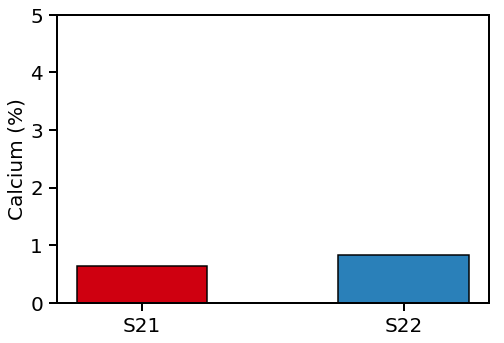

In [32]:
calcium_relation = extract_global_stats(['sample21', 'sample22'],
                                         './data/samples/porosity',
                                         'calcium')
plot_porosity_chart('calcium',
                    calcium_relation, 
                    ('sample21', 'sample22'),
                    './data/samples/Plots',
                    ylabel_ml=('Calcium (%)', u'Кальций (%)'),
                    ylim=[0,5],
                    ystep=1)

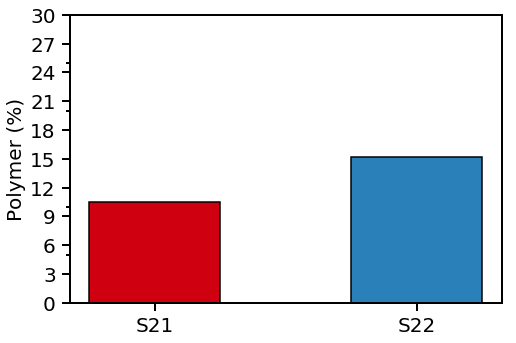

In [33]:
polymer_relation = extract_global_stats(['sample21', 'sample22'],
                                         './data/samples/porosity/',
                                         'polymer')
plot_porosity_chart('polymer',
                    polymer_relation, 
                    ('sample21', 'sample22'),
                    './data/samples/Plots',
                    ylabel_ml=('Polymer (%)', u'Полимер (%)'),
                    ylim=[0,30],
                    ystep=3)

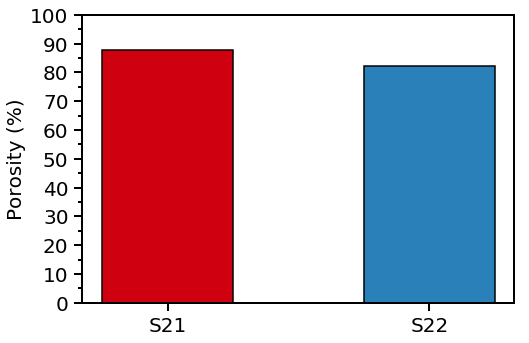

In [34]:
porosity_relation = extract_global_stats(['sample21', 'sample22'],
                                         './data/samples/porosity',
                                         'porosity')
plot_porosity_chart('porosity',
                    porosity_relation, 
                    ('sample21', 'sample22'),
                    './data/samples/Plots',
                    ylabel_ml=('Porosity (%)', u'Поросити (%)'),
                    ylim=[0,100],
                    ystep=10)

# Diameter analysis

Max: 21.9999809265, Min: 0.0
Num of particles: 1697333
1-5: 1293240
5-10: 395599
10-15: 8465
15-25: 29


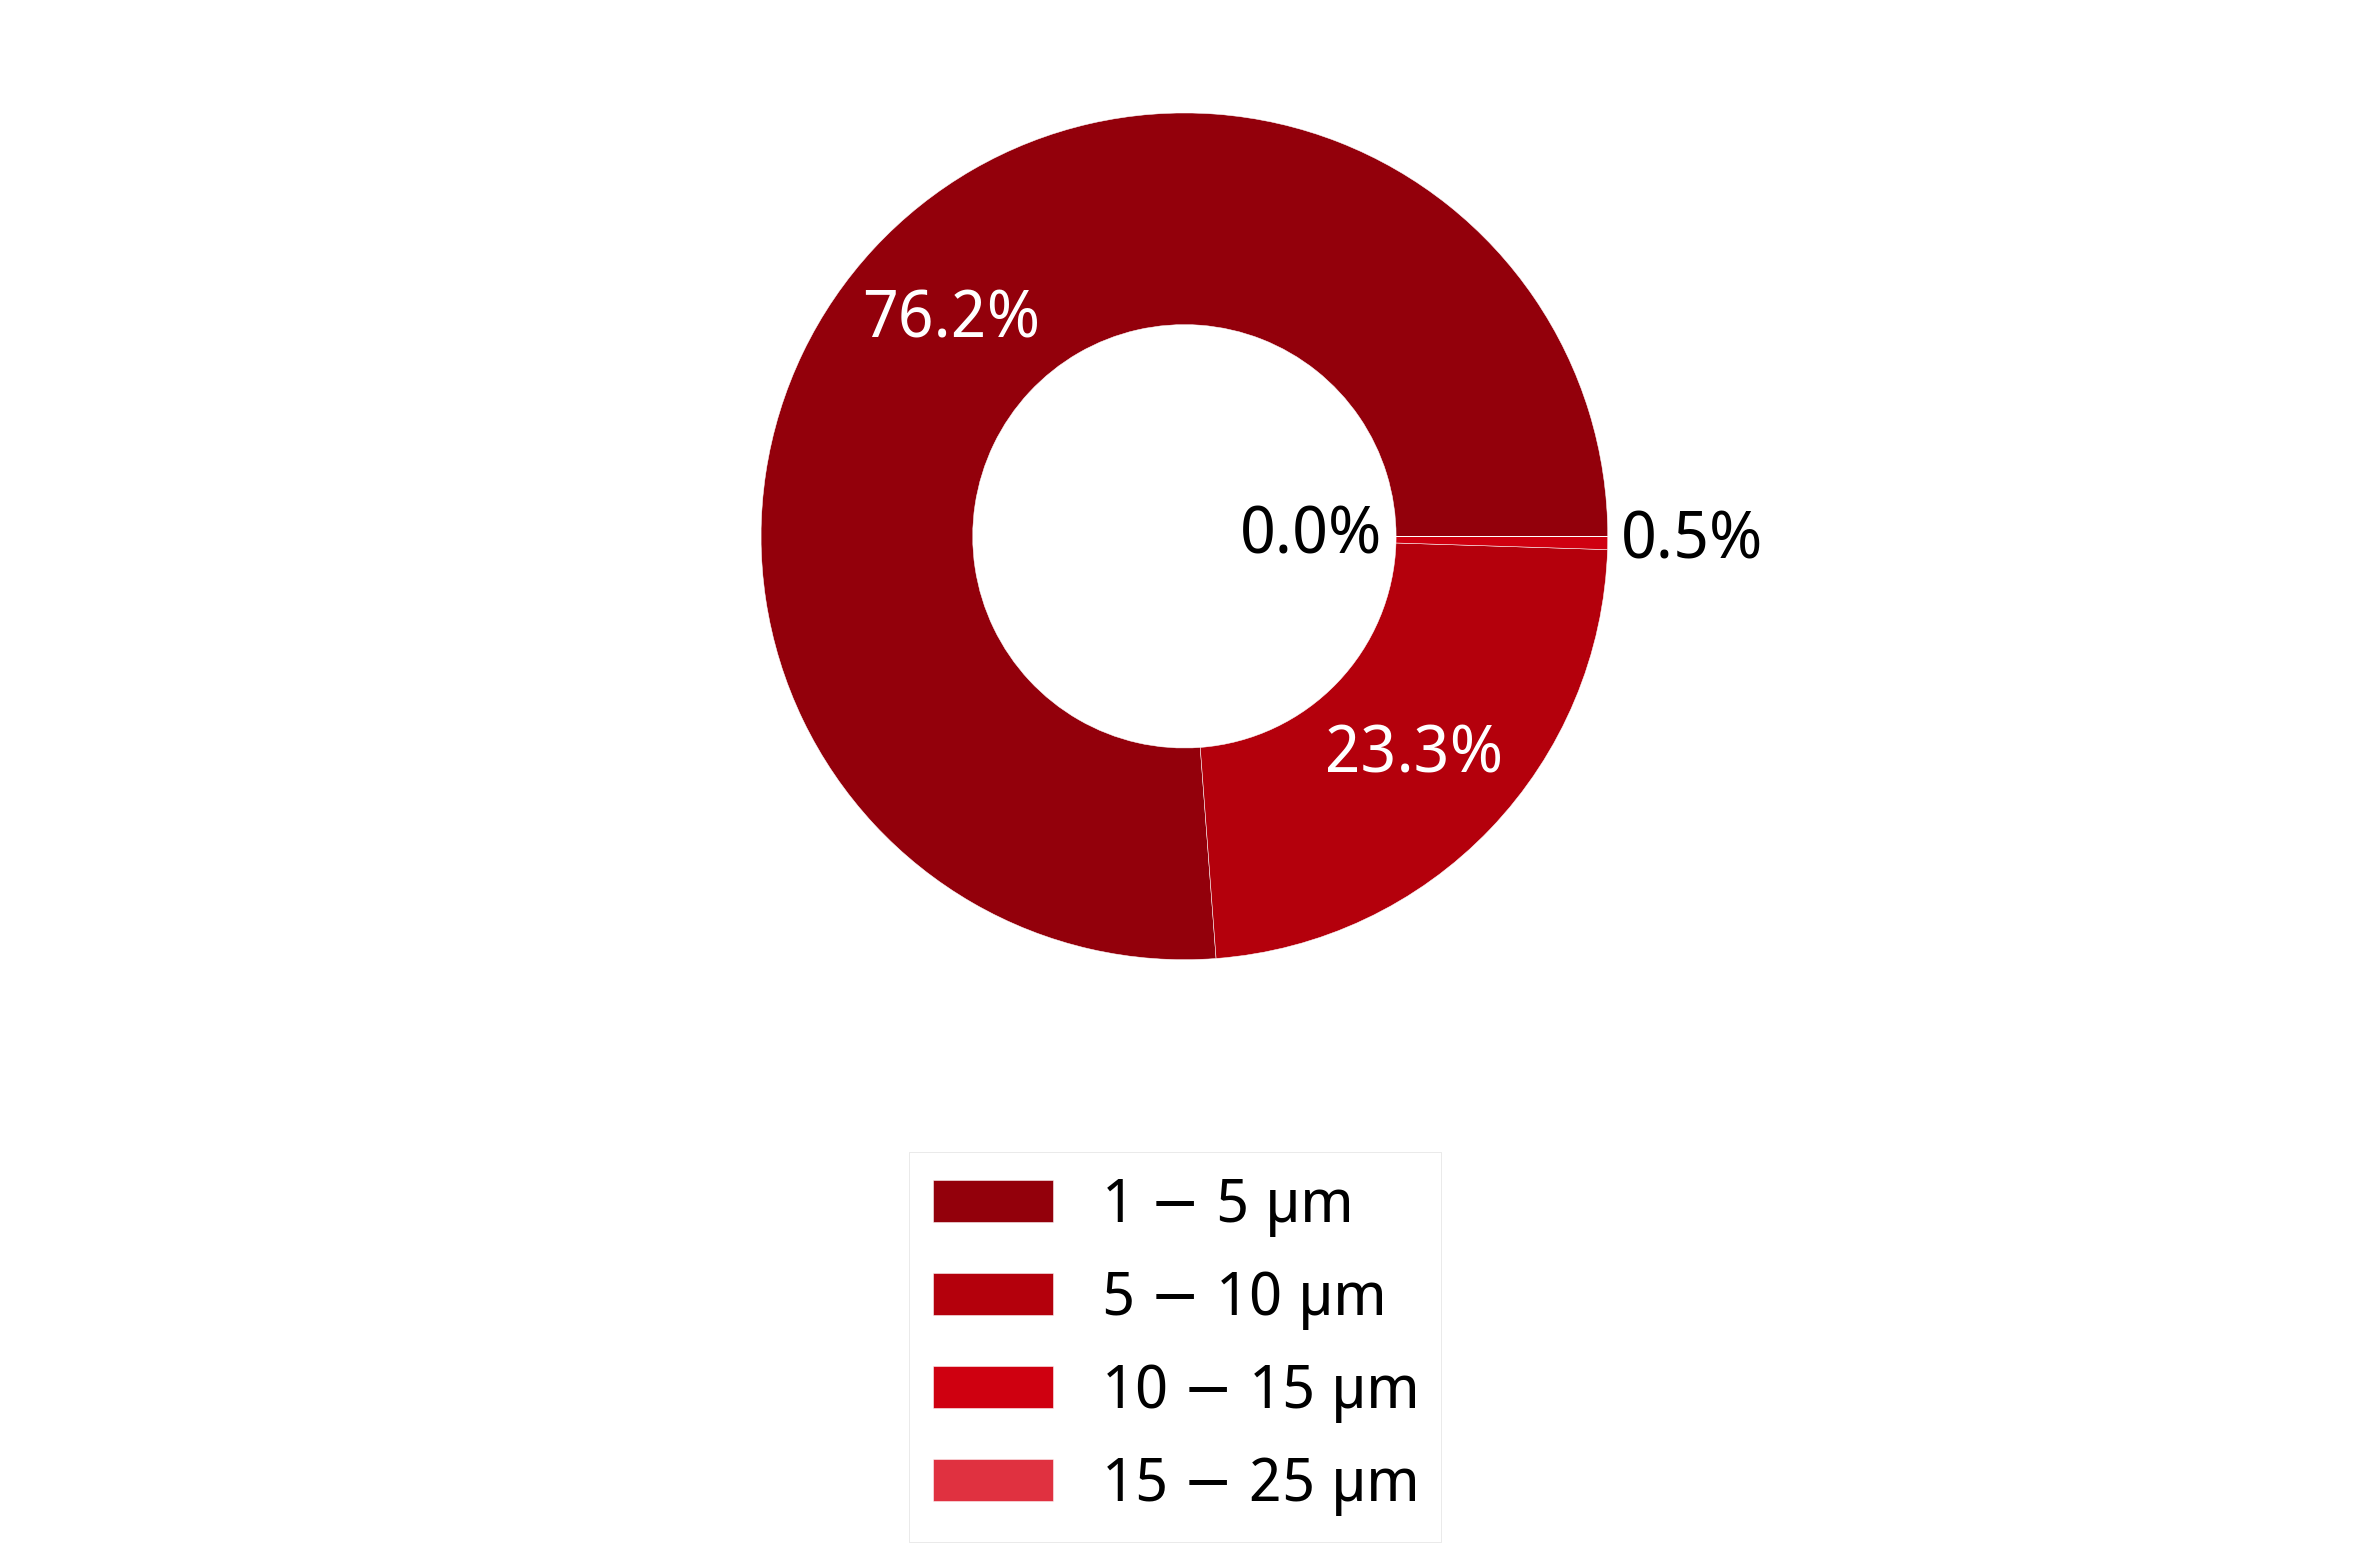

In [24]:
create_pie_chart('sample21', 
                 './data/samples/sample21/Analysis', 
                 './data/samples/Plots',
                 [(1,5), (5,10), (10,15), (15,25)], 
                 title='diameter',
                 type='d', 
                 unit_scale=1.1,
                 measure_type='Non_vol',
                 legend_fontsize=60,
                 chart_fontsize=65,
                 zebra_color=(True,2),
                 lang='en')

Max: 8.8000087738, Min: 0.0
Num of particles: 4190
1-3: 2318
3-6: 1601
6-9: 271
9-12: 0
12-15: 0


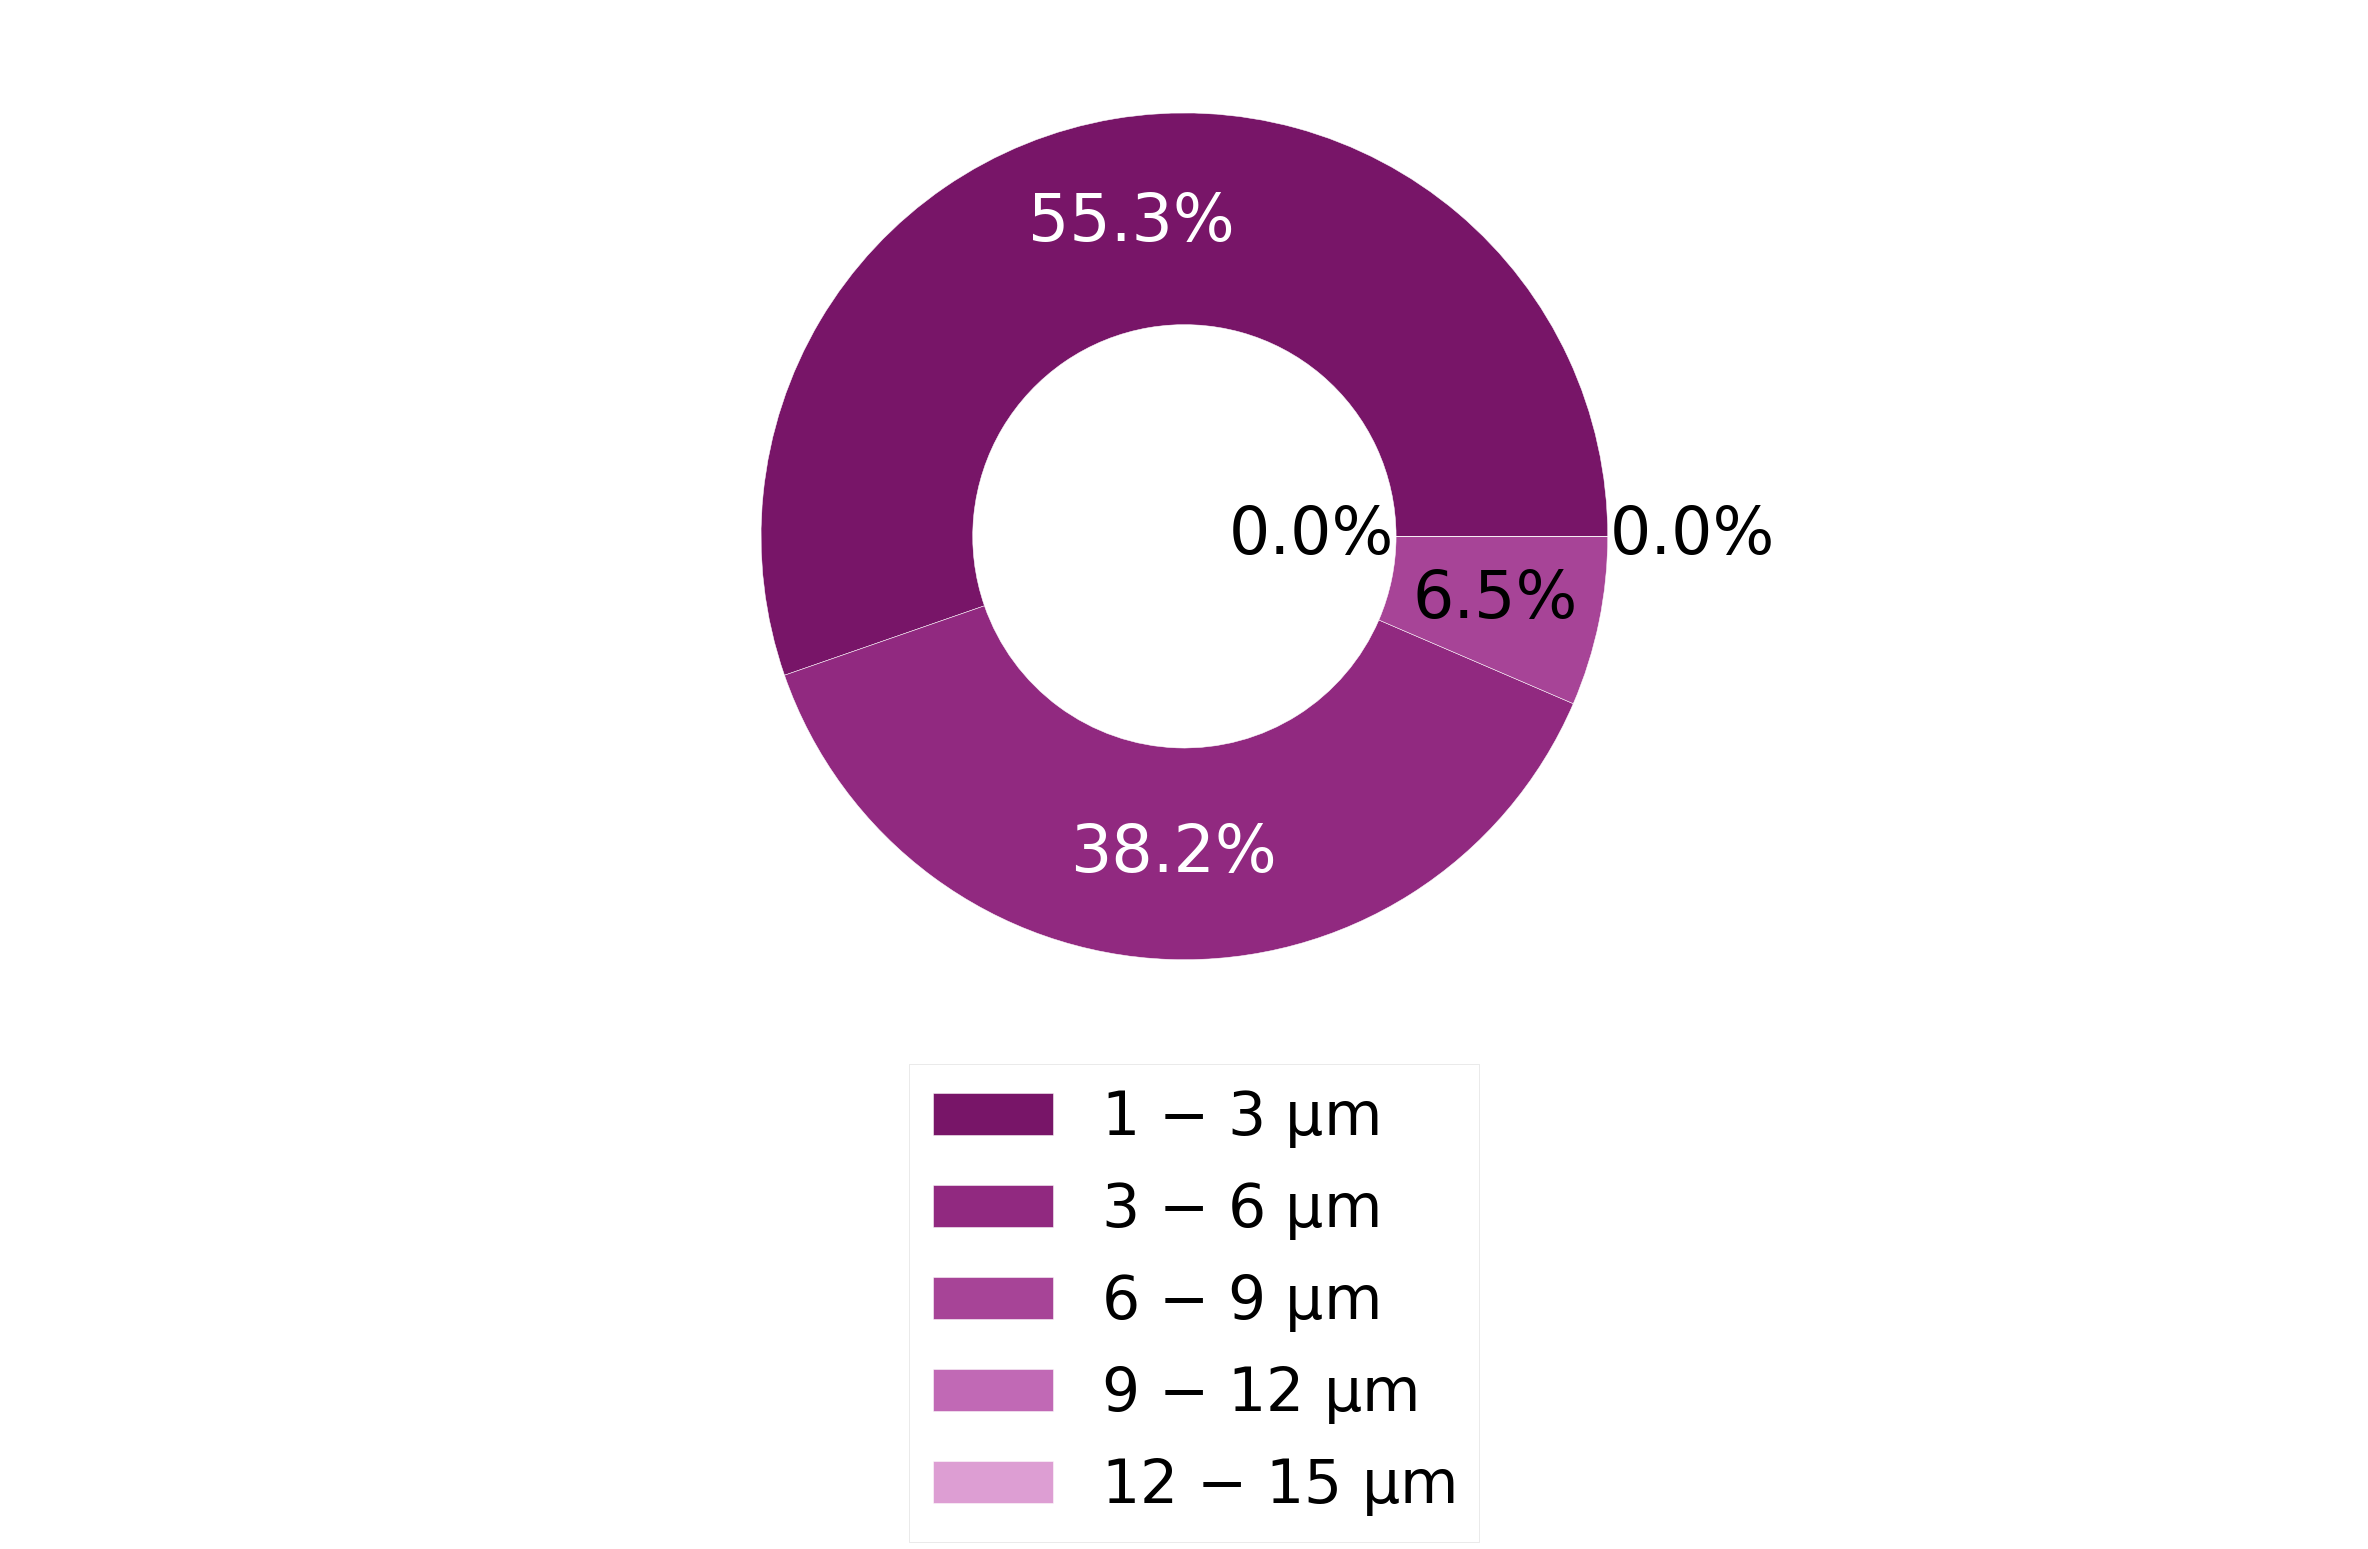

In [83]:
create_pie_chart('sample23', 
                 './data/samples/sample23/Analysis', 
                 './data/samples/Plots',
                 [(1,3), (3,6), (6,9), (9,12), (12,15)], 
                 title='diameter',
                 type='d', 
                 unit_scale=1.1,
                 measure_type='Non_vol',
                 legend_fontsize=60,
                 chart_fontsize=65,
                 zebra_color=(True,2),
                 lang='en')

Max: 13.2000007629, Min: 0.0
Num of particles: 4068
1-3: 1524
3-6: 1091
6-9: 1350
9-12: 95
12-15: 8


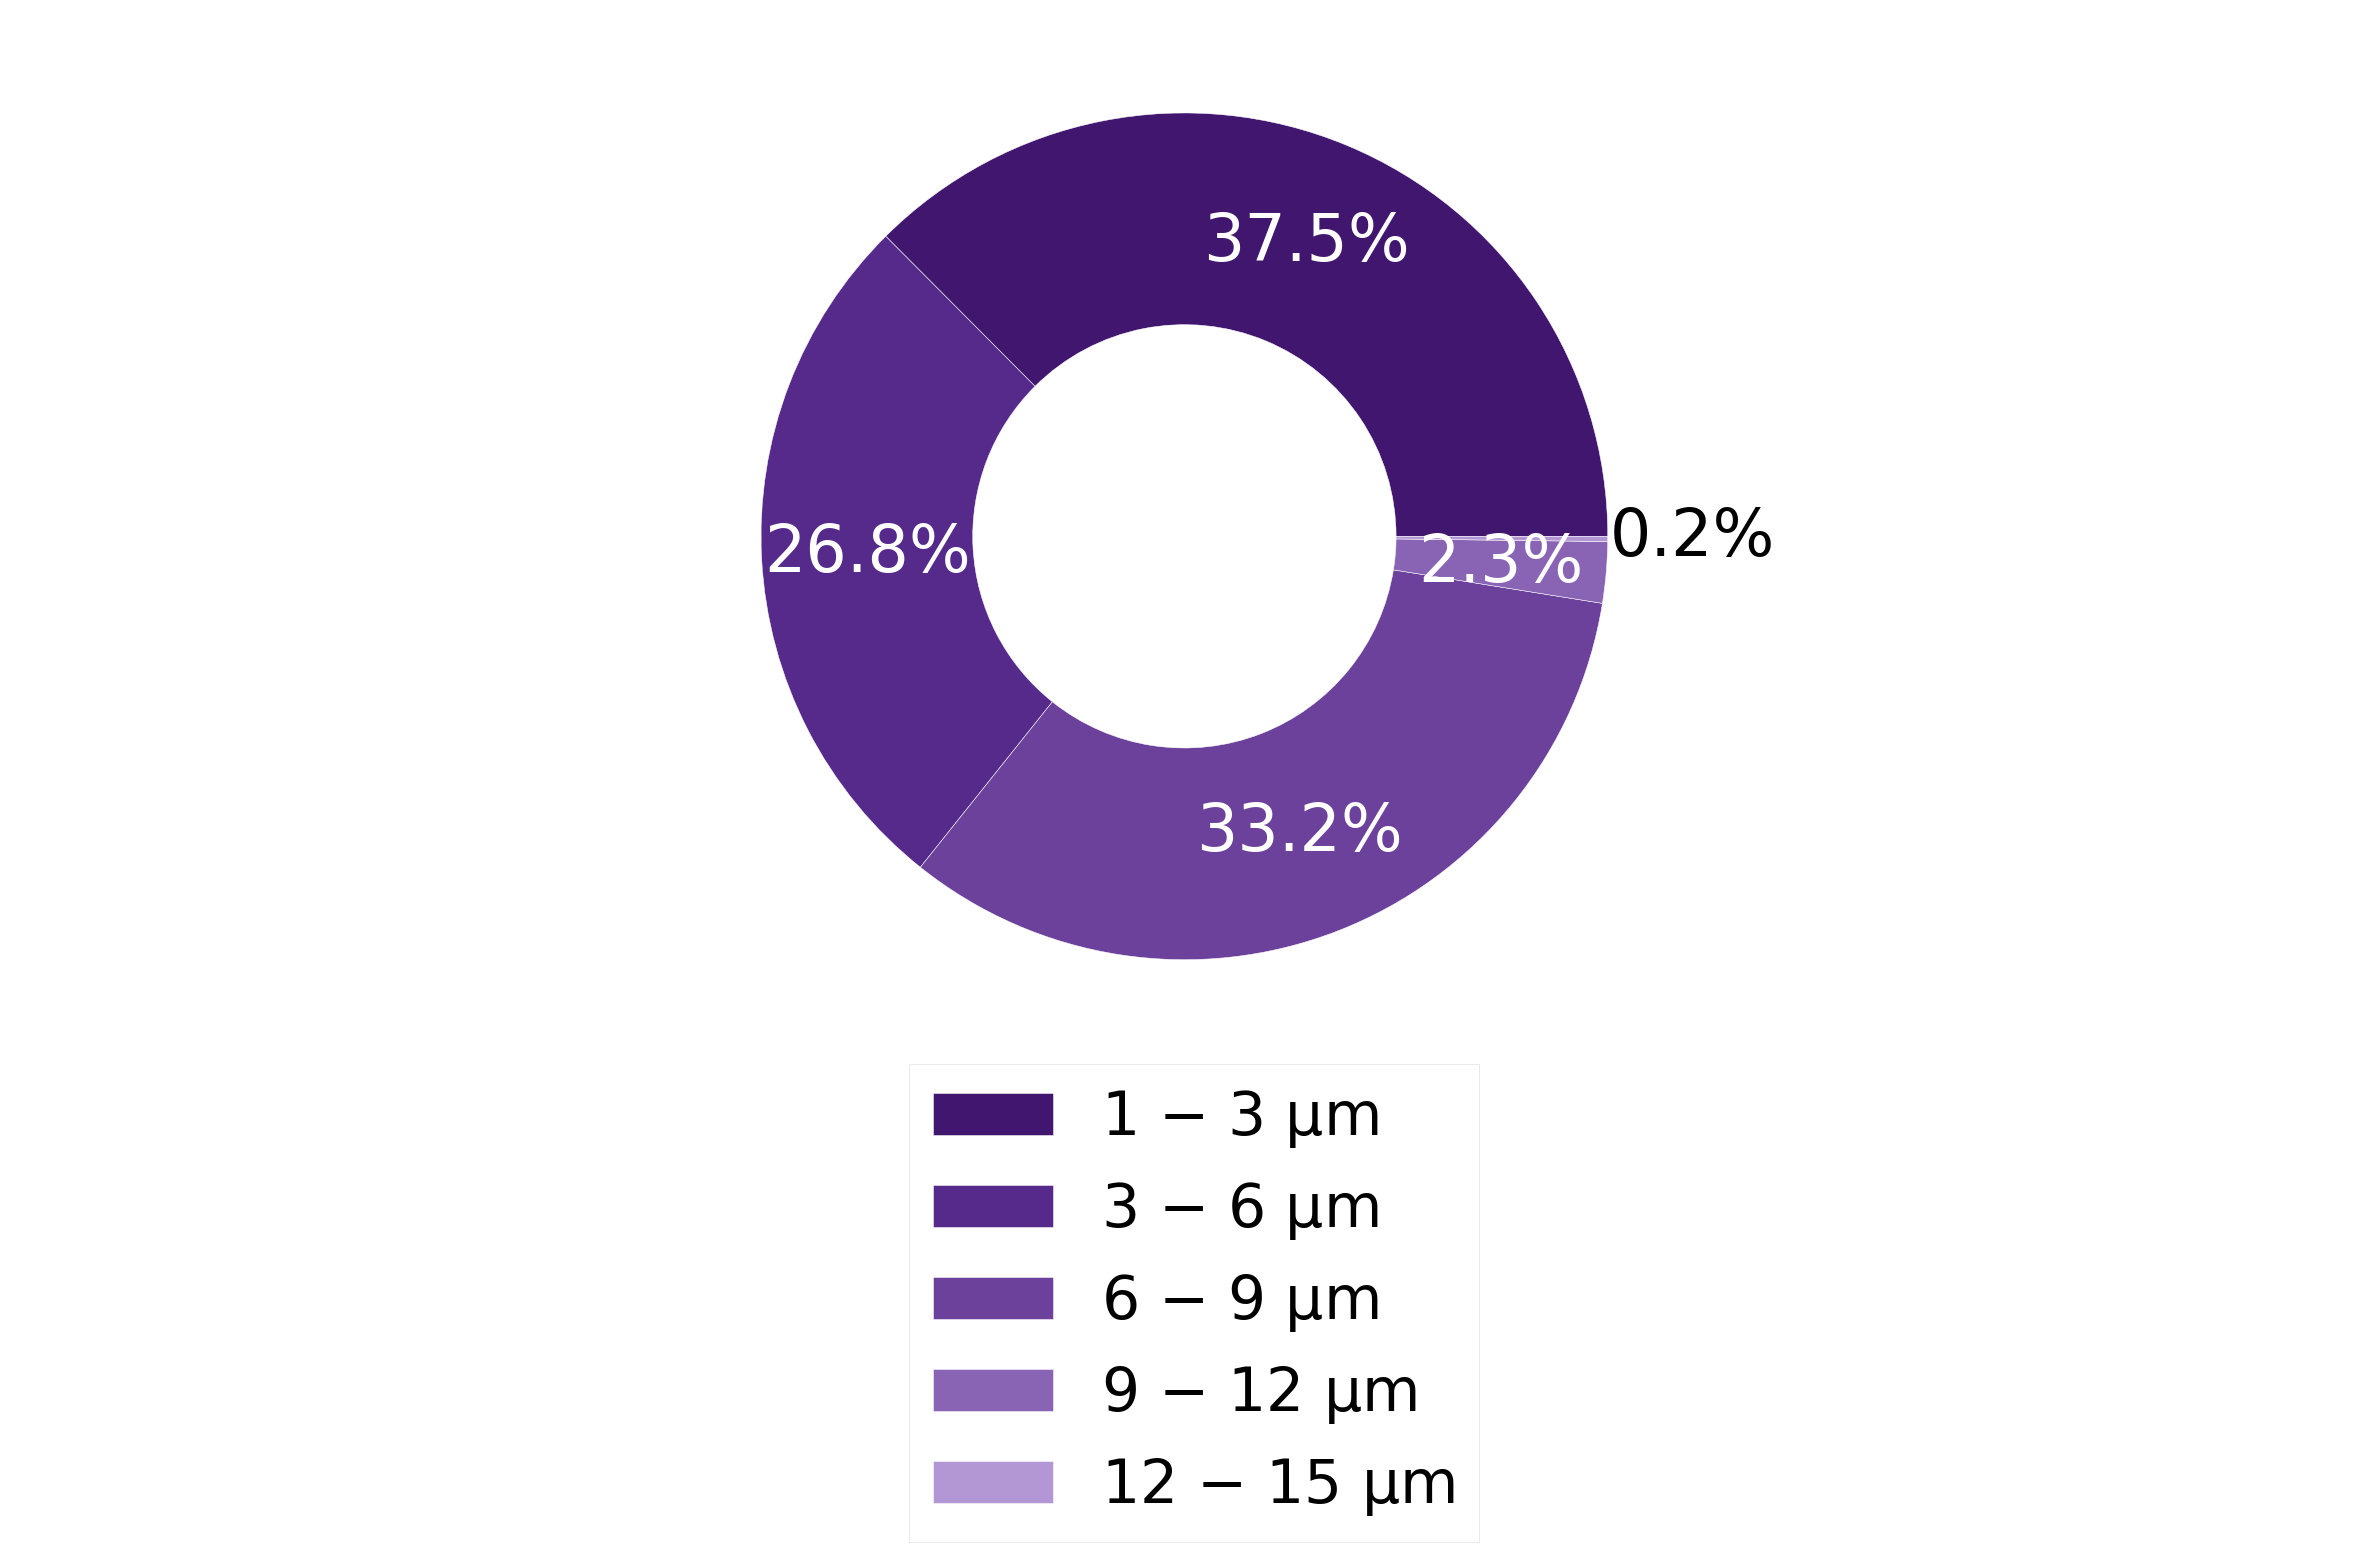

In [85]:
create_pie_chart('sample24', 
                 './data/samples/sample24/Analysis', 
                 './data/samples/Plots',
                 [(1,3), (3,6), (6,9), (9,12), (12,15)],  
                 title='diameter',
                 type='d', 
                 unit_scale=1.1,
                 measure_type='Non_vol',
                 legend_fontsize=60,
                 chart_fontsize=65,
                 zebra_color=(True,4),
                 lang='en')

Max: 10.9999580383, Min: 0.0
Num of particles: 4560
1-3: 2694
3-6: 1636
6-9: 229
9-12: 1
12-15: 0


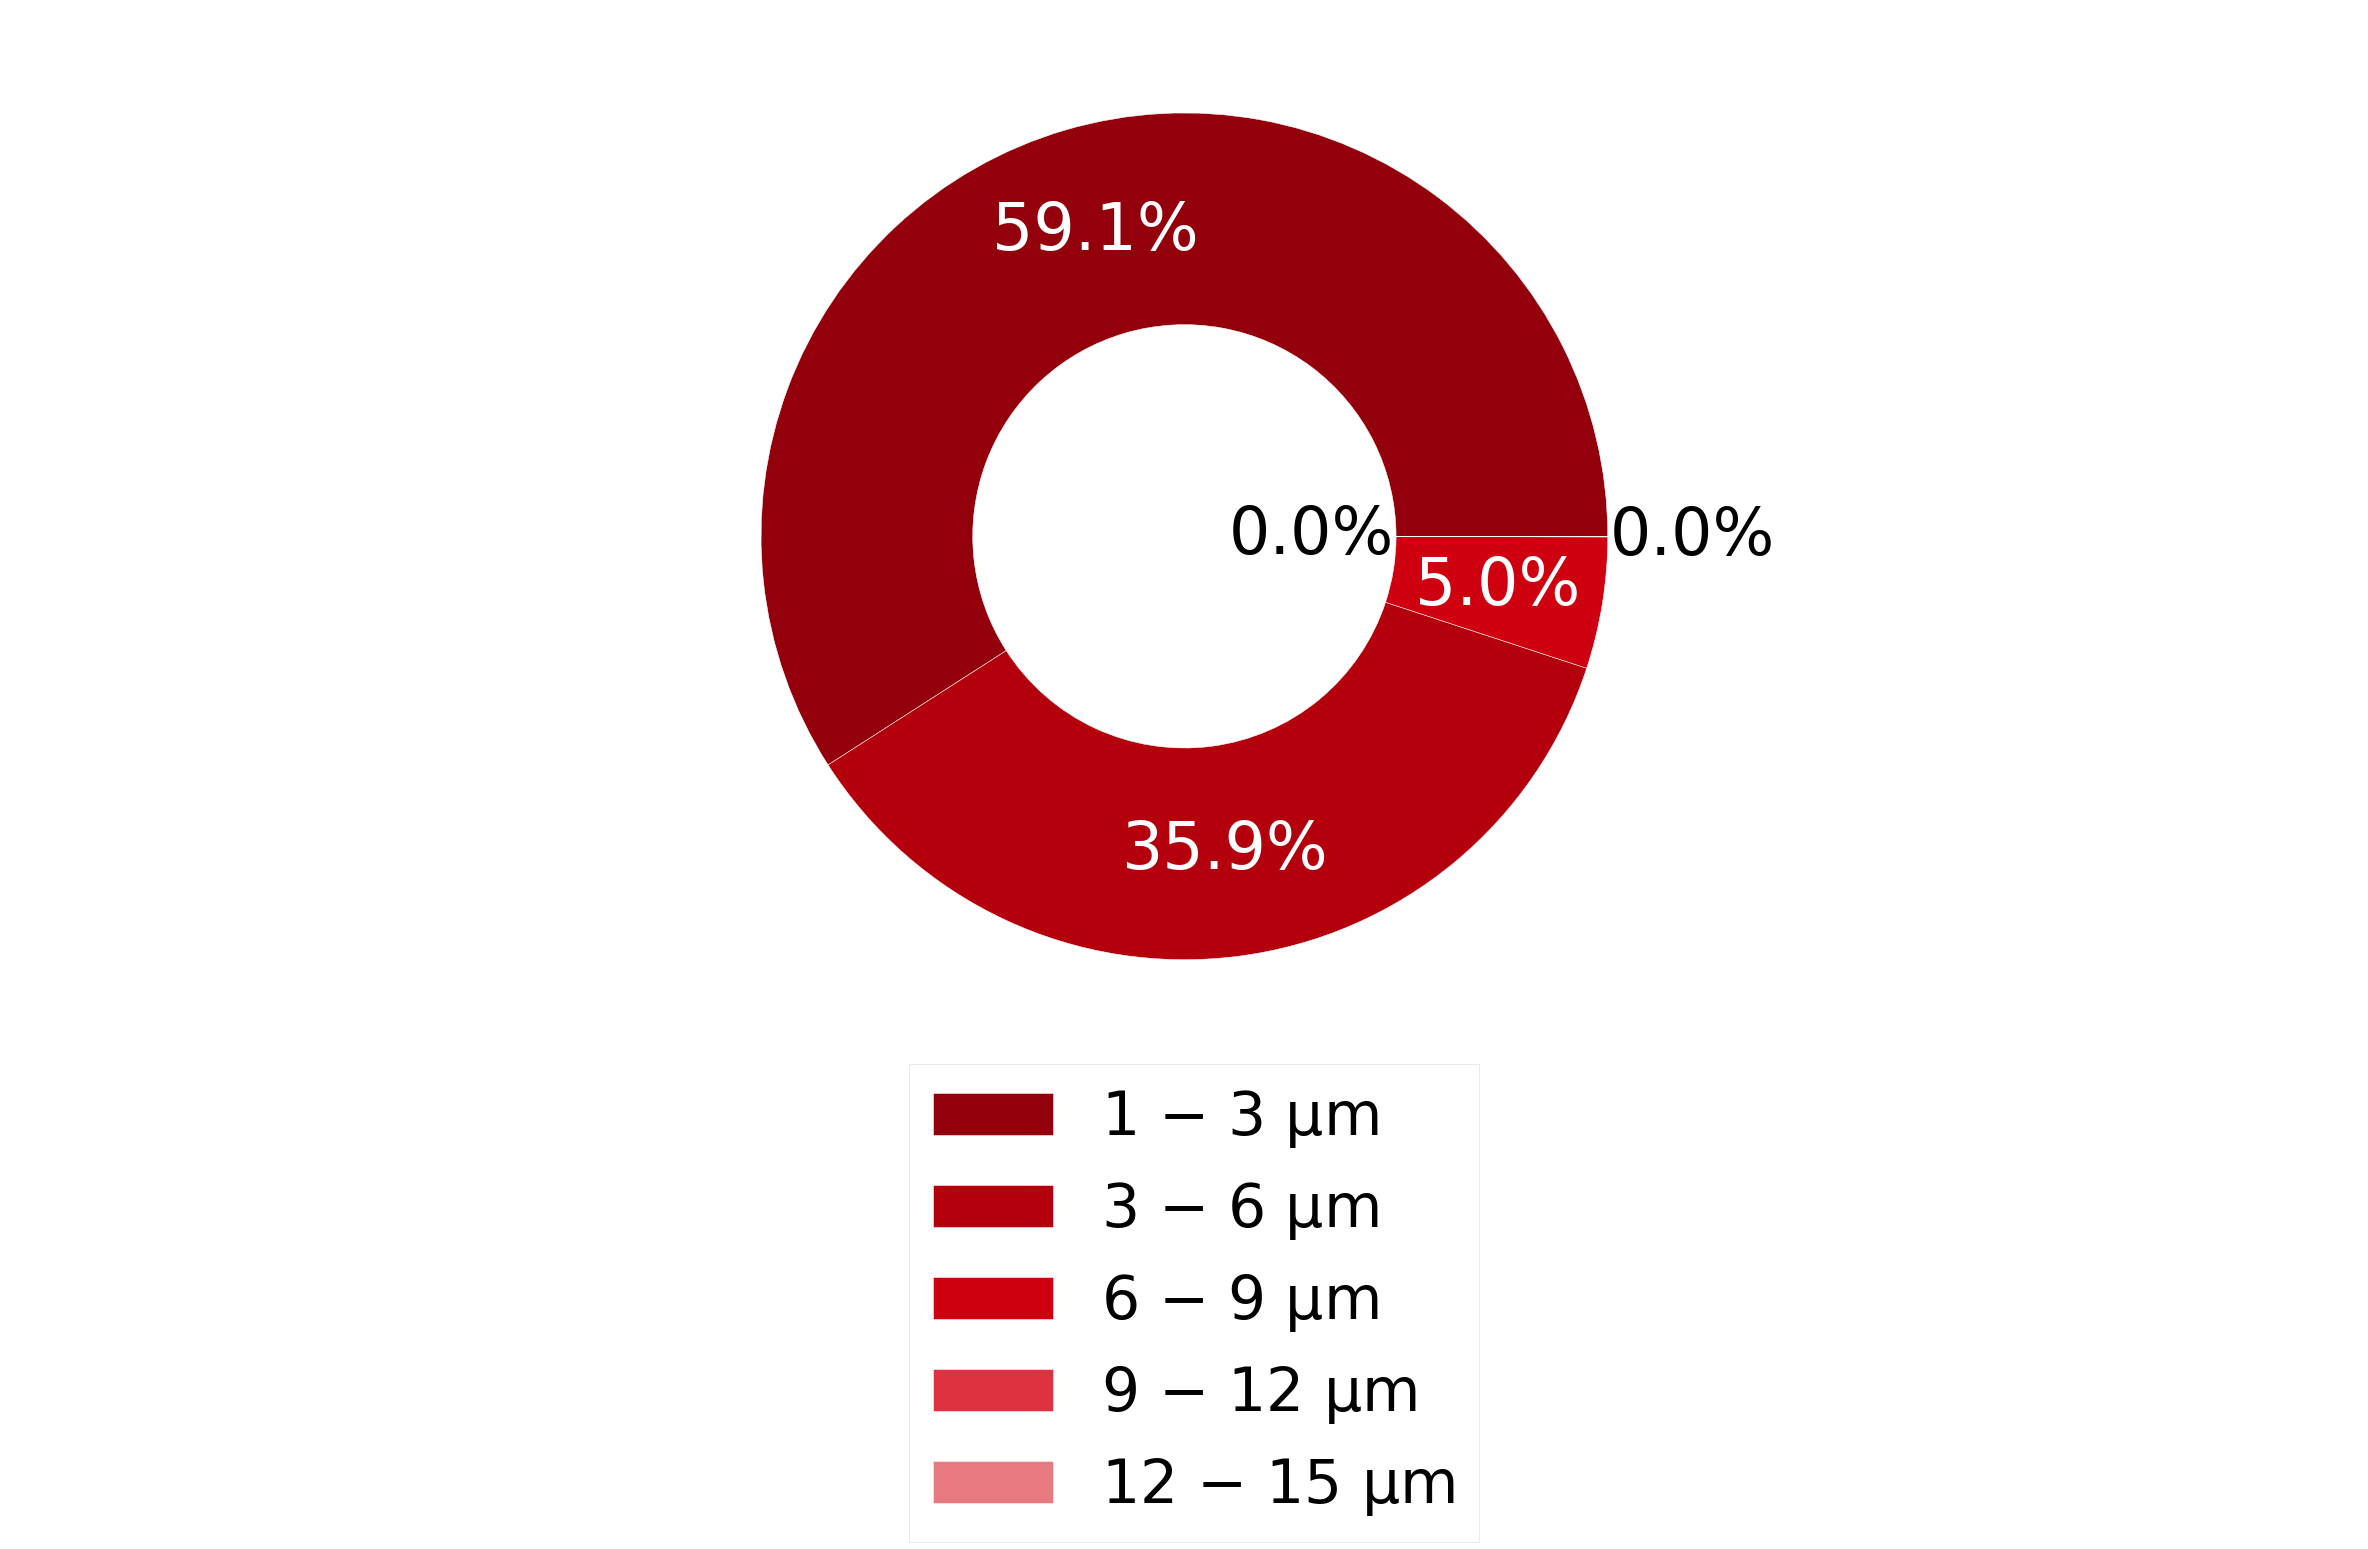

In [87]:
create_pie_chart('sample27', 
                 './data/samples/sample27/Analysis', 
                 './data/samples/Plots',
                 [(1,5), (5,10), (10,15), (15,20), (20,25)], 
                 title='diameter',
                 type='d', 
                 unit_scale=1.1,
                 measure_type='Non_vol',
                 legend_fontsize=60,
                 chart_fontsize=65,
                 zebra_color=(True,3),
                 lang='en')

Max: 11.0, Min: 0.0
Num of particles: 4544
1-3: 1999
3-6: 1282
6-9: 1240
9-12: 23
12-15: 0


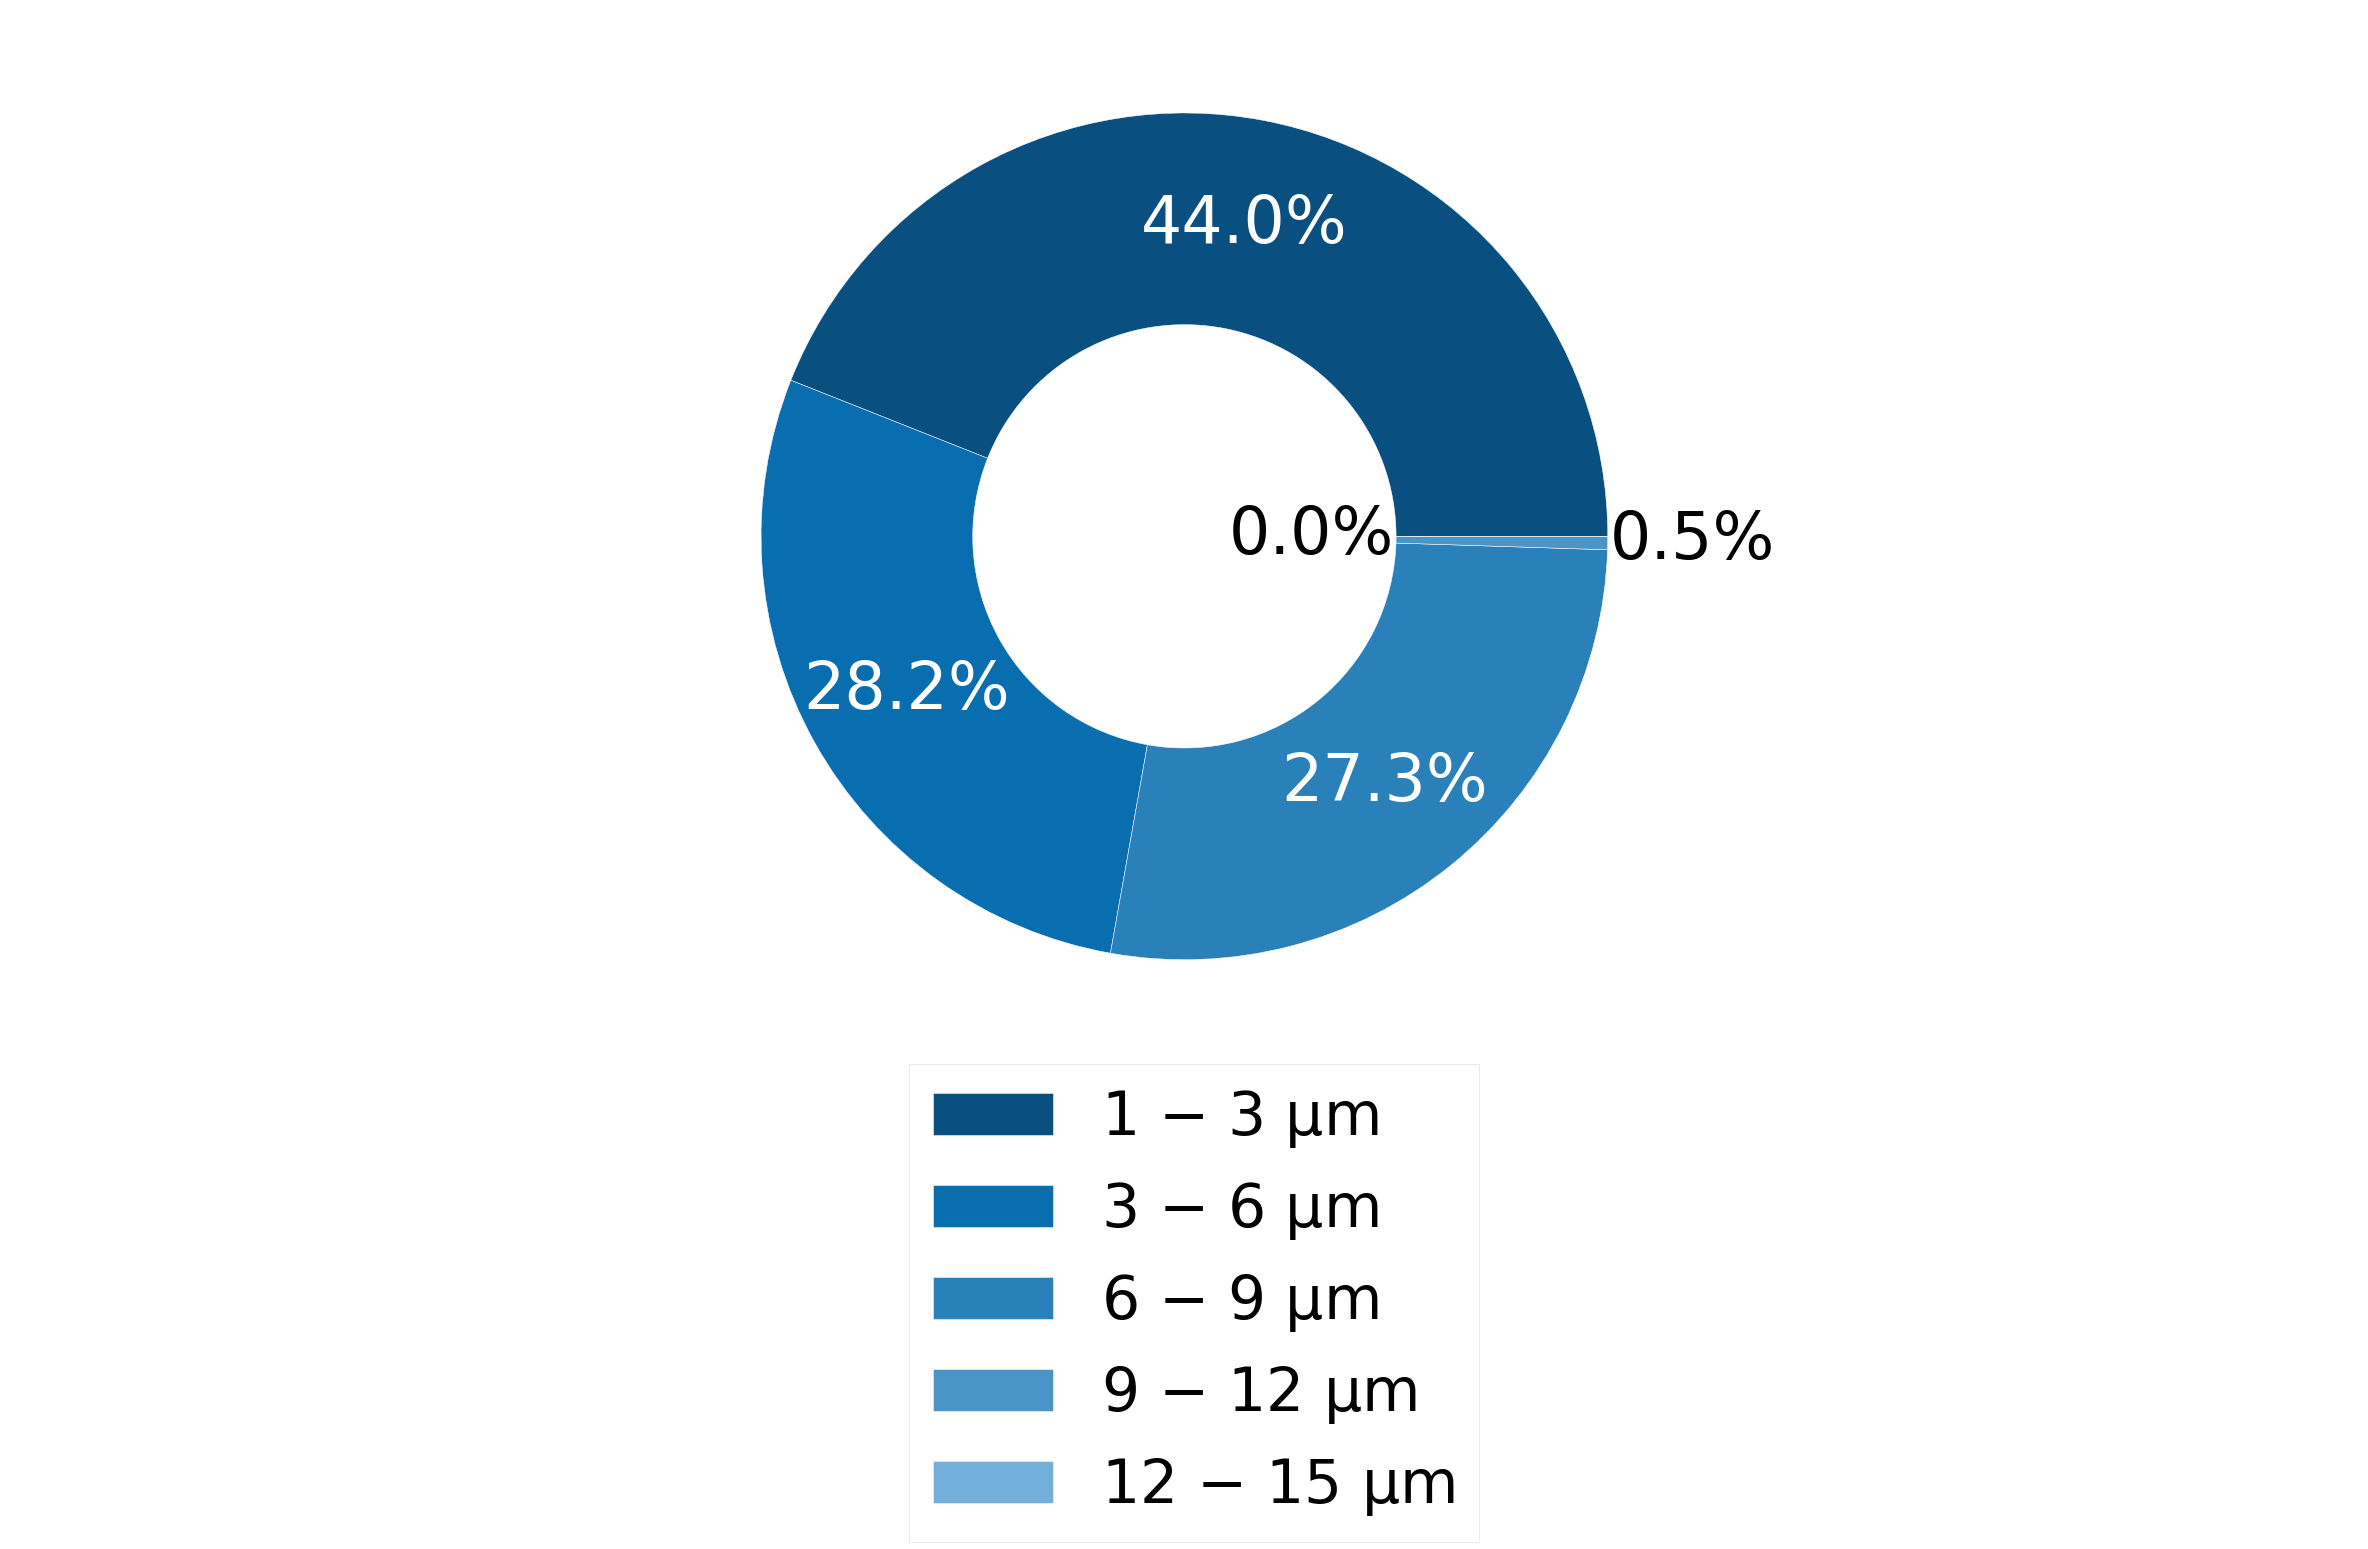

In [89]:
create_pie_chart('sample28', 
                 './data/samples/sample28/Analysis', 
                 './data/samples/Plots',
                 [(1,3), (3,6), (6,9), (9,12), (12,15)], 
                 title='diameter',
                 type='d', 
                 unit_scale=1.1,
                 measure_type='Non_vol',
                 legend_fontsize=60,
                 chart_fontsize=65,
                 zebra_color=(True,3),
                 lang='en')

# Orientation analysis

Sample: sample23 (/mnt/LSDF/tomo/rshkarin/Svetastuff/Chernozem/data_for_orientation_and_diameter/sample23/Analysis/sample23_w32_orientation_evaluation.npy)
1.35501737078
3.55047417793


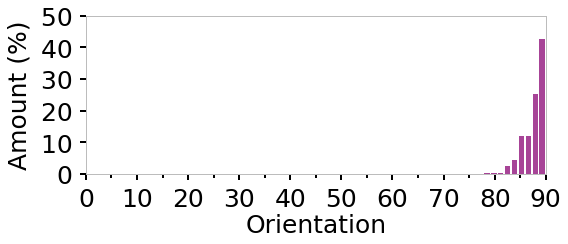

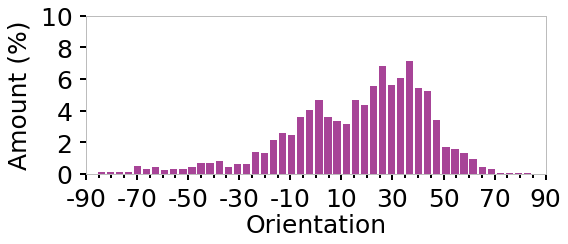

In [108]:
plot_from_samples('./data/samples/sample23/Analysis',
                  ['sample23'],
                  dict(azth=('Azimuth', (-90., 90.), 48, (0.0, 0.1), np.linspace(0., 0.1, num=6)), 
                       lat=('Latitude', (0.,90.), 12, (0.0, 0.5), np.linspace(0., 0.5, num=6))),
                  './data/samples/Plots',
                  COLORS['sample23'][2],
                  type='o',
                  xlabel='Orientation', 
                  ylabel='Amount (%)',
                  exp_fontsize=20,
                  labels_fontsize=25,
                  grid_alpha=0.3,
                  ticks_pad=7,
                  yticks_fontsize=25,
                  xticks_fontsize=25,
                  bar_width=0.8,
                  title_fontsize=25,
                  figsize=(8,3.5),
                  norm=False,
                  in_percent=True)

Sample: sample24 (/mnt/LSDF/tomo/rshkarin/Svetastuff/Chernozem/data_for_orientation_and_diameter/sample24/Analysis/sample24_w32_orientation_evaluation.npy)
1.33785950466
3.74891977513


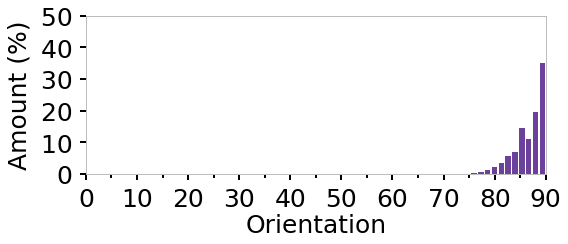

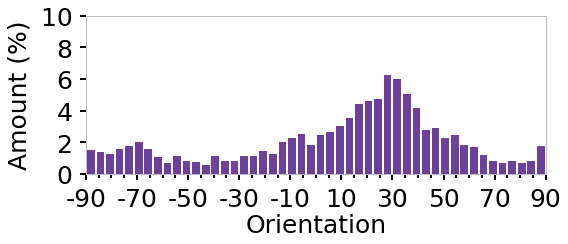

In [109]:
plot_from_samples('./data/samples/sample24/Analysis',
                  ['sample24'],
                  dict(azth=('Azimuth', (-90., 90.), 48, (0.0, 0.1), np.linspace(0., 0.1, num=6)), 
                       lat=('Latitude', (0.,90.), 12, (0.0, 0.5), np.linspace(0., 0.5, num=6))),
                  './data/samples/Plots',
                  COLORS['sample24'][2],
                  type='o',
                  xlabel='Orientation', 
                  ylabel='Amount (%)',
                  exp_fontsize=20,
                  labels_fontsize=25,
                  grid_alpha=0.3,
                  ticks_pad=7,
                  yticks_fontsize=25,
                  xticks_fontsize=25,
                  bar_width=0.8,
                  title_fontsize=25,
                  figsize=(8,3.5),
                  norm=False,
                  in_percent=True)

Sample: sample27 (/mnt/LSDF/tomo/rshkarin/Svetastuff/Chernozem/data_for_orientation_and_diameter/sample27/Analysis/sample27_w32_orientation_evaluation.npy)
1.53145729671
2.52589484467


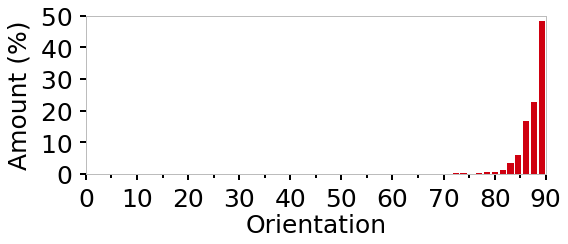

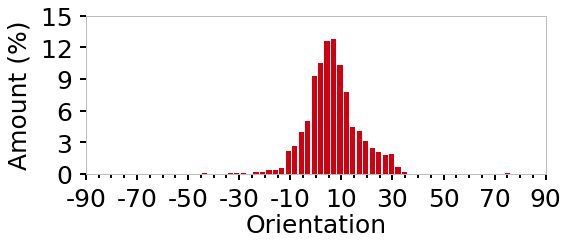

In [112]:
plot_from_samples('./data/samples/sample27/Analysis',
                  ['sample27'],
                  dict(azth=('Azimuth', (-90., 90.), 48, (0.0, 0.15), np.linspace(0., 0.15, num=6)), 
                       lat=('Latitude', (0.,90.), 12, (0.0, 0.5), np.linspace(0., 0.5, num=6))),
                  './data/samples/Plots',
                  COLORS['sample27'][2],
                  type='o',
                  xlabel='Orientation', 
                  ylabel='Amount (%)',
                  exp_fontsize=20,
                  labels_fontsize=25,
                  grid_alpha=0.3,
                  ticks_pad=7,
                  yticks_fontsize=25,
                  xticks_fontsize=25,
                  bar_width=0.8,
                  title_fontsize=25,
                  figsize=(8,3.5),
                  norm=False,
                  in_percent=True)

Sample: sample28 (/mnt/LSDF/tomo/rshkarin/Svetastuff/Chernozem/data_for_orientation_and_diameter/sample28/Analysis/sample28_w32_orientation_evaluation.npy)
1.2850481539
3.23886181763


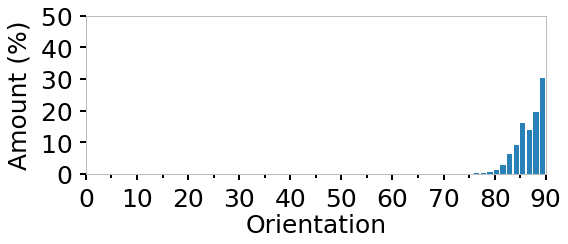

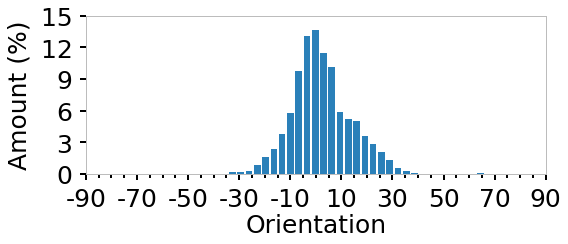

In [113]:
plot_from_samples('./data/samples/sample28/Analysis',
                  ['sample28'],
                  dict(azth=('Azimuth', (-90., 90.), 48, (0.0, 0.15), np.linspace(0., 0.15, num=6)), 
                       lat=('Latitude', (0.,90.), 12, (0.0, 0.5), np.linspace(0., 0.5, num=6))),
                  './data/samples/Plots',
                  COLORS['sample28'][2],
                  type='o',
                  xlabel='Orientation', 
                  ylabel='Amount (%)',
                  exp_fontsize=20,
                  labels_fontsize=25,
                  grid_alpha=0.3,
                  ticks_pad=7,
                  yticks_fontsize=25,
                  xticks_fontsize=25,
                  bar_width=0.8,
                  title_fontsize=25,
                  figsize=(8,3.5),
                  norm=False,
                  in_percent=True)

# Statistical analysis

In [18]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.libqsturng import psturng
import statsmodels.sandbox.stats.multicomp as multi

In [19]:
def calculate_tukey_posthoc2(df, column, type_column='Type', verbose=True):
    mc = MultiComparison(df[column], df[type_column])
    result = mc.tukeyhsd()
    st_range = np.abs(result.meandiffs) / result.std_pairs
    
    if verbose:
        print 'Tukey post-hoc ({0})'.format(column)
        print result
        print mc.groupsunique

    out = {}
    groups = mc.groupsunique
    pvals = [multi.tukey_pvalues(ii, len(result.groupsunique), result.df_total)[0] for ii in st_range]
    g1idxs, g2idxs = mc.pairindices
    
    for g1i, g2i, p in zip(g1idxs, g2idxs, pvals):
        gname = '{0}-{1}'.format(groups[g1i], groups[g2i])
        out[gname] = p
        
    import operator
    min_item = min(out.iteritems(), key=operator.itemgetter(1))
    
    if verbose:
        for grp, p in out.items():
            print grp, ': ', p
    
    return out, min_item

In [20]:
def calculate_tukey_posthoc(df, column, type_column='type', verbose=True, name=None, write=False, output_dir=None):
    mc = MultiComparison(df[column], df[type_column])
    tt = mc.tukeyhsd()
    st_range = np.abs(tt.meandiffs) / tt.std_pairs
    
    fout = None
    if write and output_dir:
        fout = open(os.path.join(output_dir, name + '.txt'), 'w')
        print os.path.join(output_dir, name + '.txt')
    
    if verbose:
        if fout:
            print >> fout, 'Tukey post-hoc ({0})'.format(column)
            print >> fout, tt
            print >> fout, mc.groupsunique
        else:
            print 'Tukey post-hoc ({0})'.format(column)
            print tt
            print mc.groupsunique
        
    pvals = psturng(st_range, len(tt.groupsunique), tt.df_total)
    
    out = {}
    groups = mc.groupsunique
    g1idxs, g2idxs = mc.pairindices
    
    for g1i, g2i, p in zip(g1idxs, g2idxs, pvals):
        gname = '{}-{}'.format(groups[g1i], groups[g2i])
        out[gname] = p
        
    import operator
    min_item = min(out.iteritems(), key=operator.itemgetter(1))
    
    if verbose:
        for grp, p in out.items():
            if fout:
                print >> fout, '{}: {}'.format(grp, p)
            else:
                print grp, ': ', p
    
    return out, min_item

In [21]:
def collect_porosity_stats(input_dir, sample_names, parts=(3,3), filename_tmpl='porosity_{}_part{}.txt'):
    df = pd.DataFrame(np.empty(0, dtype=[('porosity', 'f8'), ('type', 'S20')]))
    
    for sn in sample_names:
        for pn in xrange(reduce(lambda x, y: x*y, parts)):
            input_filepath = os.path.join(input_dir, sn, 'part_{}'.format(pn), filename_tmpl.format(sn, pn))
            val = np.loadtxt(input_filepath, dtype=np.float32).item()
            df = df.append({'porosity': val, 'type': sn}, ignore_index=True)
        
    for sn in sample_names:
        print 'Porosity [{}]: Mean: {} , Std: {}'.format(sn, 
                                                         df[df['type'] == sn]['porosity'].mean() * 100., 
                                                         df[df['type'] == sn]['porosity'].std() * 100.)
            
    return df

In [630]:
df_porosity = collect_porosity_stats('./data/', ['PCL_SiHA_cl', 'PCL_SiHA_wa', 'PCL_cl', 'PCL_wa'])

Porosity [PCL_SiHA_cl]: Mean: 75.4984855652 , Std: 3.34969234313
Porosity [PCL_SiHA_wa]: Mean: 73.0435629686 , Std: 1.86535514643
Porosity [PCL_cl]: Mean: 83.8676055272 , Std: 0.489019014001
Porosity [PCL_wa]: Mean: 76.1281801595 , Std: 1.13639550189


In [647]:
_, _ = calculate_tukey_posthoc(df_porosity, 
                               'porosity',
                               name='samples_porosity',
                               write=False, 
                               output_dir='./data/Statistics')

Tukey post-hoc (porosity)
   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      group2   meandiff  lower   upper  reject
-------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa -0.0245  -0.0503  0.0012 False 
PCL_SiHA_cl    PCL_cl    0.0837   0.058   0.1094  True 
PCL_SiHA_cl    PCL_wa    0.0063  -0.0194  0.032  False 
PCL_SiHA_wa    PCL_cl    0.1082   0.0825  0.134   True 
PCL_SiHA_wa    PCL_wa    0.0308   0.0051  0.0566  True 
   PCL_cl      PCL_wa   -0.0774  -0.1031 -0.0517  True 
-------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.0658670894348
PCL_SiHA_wa-PCL_cl :  0.001
PCL_SiHA_wa-PCL_wa :  0.0137946199136
PCL_cl-PCL_wa :  0.001
PCL_SiHA_cl-PCL_wa :  0.9
PCL_SiHA_cl-PCL_cl :  0.001


# Mechanical statistics analysis

In [ ]:
# 8389, 6002

In [179]:
df_num_partls = pd.DataFrame({'num_of_particles': [7300, 
                                    8100, 
                                    6100,    
                                    6002,
                                    6890,
                                    5200], 
                         'type': ['PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa']})

In [180]:
_, _ = calculate_tukey_posthoc(df_num_partls, 
                               'num_of_particles', 
                               name='samples_num_of_particles_v2', 
                               write=False, 
                               output_dir='./data/Statistics')

Tukey post-hoc (num_of_particles)
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
   group1      group2   meandiff   lower     upper   reject
-----------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa -1136.0  -3243.1582 971.1582 False 
-----------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.208781744457
